In [64]:
import openai
import os
import pandas as pd
import tweepy
import openai
import re
from tqdm import tqdm
import seaborn as sns


# Function for getting data given a ticker
def getData(ticker,data):
    tweet_dataset = []
    tweets = twitterAPI.search_tweets(q=ticker + ' -filter:retweets -filter:replies',
                                      lang="en",
                                      result_type="recent",
                                      count=data
                                      )
    for tweet in tweets:
        tweet_content = {'id': tweet.id,
                         'date': tweet.created_at,
                         'user_name': tweet.user.screen_name,
                         'text': tweet.text,
                         }

        tweet_dataset.append(tweet_content)

    tweet_dataframe = pd.DataFrame(tweet_dataset)
    return tweet_dataframe


# Function for getting sentiment of tweet
def get_sentiment(text, ticker):
    prompt_text = """Classify the sentiment of the following tweet as positive, negative, or neutral towards {}.
    text: {}
    sentiment: """.format(ticker, text)

    sentiment = openai.Completion.create(
        model="gpt-3.5-turbo",
        prompt=prompt_text,
        max_tokens=15,
        temperature=0,
    )

    # remove special characters e.g n etc, from response
    sentiment = re.sub('W+', '', sentiment['choices'][0]['text'].strip())

    return sentiment


# Put in your tokens for twitter
consumer_key = "<Your Key>"
consumer_secret = "<Your Secret>"
bearer_token = "<Your Bearer Token>"
# Put in your OpenAI api key and base
openai.api_key = '<Your API Key>'
openai.api_base = '<Your API Base>'

# Connect to the Twitter API
auth = tweepy.AppAuthHandler(consumer_key, consumer_secret)
twitterAPI = tweepy.API(auth)

In [65]:
# Supply the key word, and the ammount of data you want and get your pandas dataframe
data = 100
keyWord = "Bitcoin"
tweet_df = getData(keyWord,data)

#Make the index the date and sort by ascending order
tweet_df['date'] = pd.to_datetime(tweet_df['date'])
tweet_df.set_index('date', inplace=True)
tweet_df = tweet_df.sort_values(by='date', ascending=True)
tweet_df.head()

,id,user_name,text
date,,,
2023-04-27 19:44:15+00:00,1651673635579469824,0xEthereumYoda,#Ethereum price update: \n\n#ETH $1925.36 USD\...
2023-04-27 19:44:16+00:00,1651673636179173377,0xlimit777,❤️Projects with 100X potential❤️\n\n- $GENE: D...
2023-04-27 19:44:18+00:00,1651673646463688704,USAO_DC,Ohio Man Sentenced for Stealing Over 712 Bitco...
2023-04-27 19:44:22+00:00,1651673662406160406,shardnft_space,Building on Shardeum 🚀\n.........................
2023-04-27 19:44:31+00:00,1651673699928403988,eurexcoinLTD,1: Bitcoin price is $29751.07 (0.09% 1h)\n2: E...


100%|██████████| 80/80 [01:57<00:00,  1.47s/it]

Neutral     57
Positive    17
Negative     6
Name: sentiment, dtype: int64


<AxesSubplot:xlabel='sentiment', ylabel='count'>

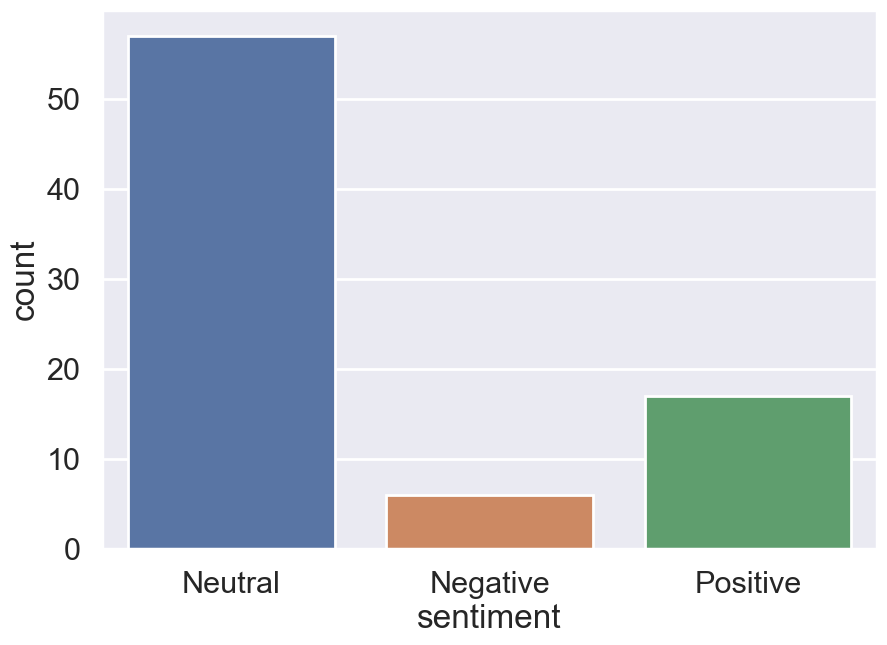

In [66]:
tqdm.pandas()

# Create the sentiment column using the get_sentiment function
tweet_df['sentiment'] = tweet_df['text'].progress_apply(lambda x: get_sentiment(x, keyWord))

# Create a dark grid
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize': (10, 7)})
sns.set_context("poster")

# Display a count of the sentiment and its corresponding visual grid
print(tweet_df['sentiment'].value_counts())
sns.countplot(x='sentiment', data=tweet_df)

In [68]:
# Keep a running count of positive negative and neutral sentiment
tweet_df['positive_sent'] = tweet_df['sentiment'].eq('Positive').cumsum()
tweet_df['negative_sent'] = tweet_df['sentiment'].eq('Negative').cumsum()
tweet_df['neutral_sent'] = tweet_df['sentiment'].eq('Neutral').cumsum()
tweet_df.head()

,id,user_name,text,sentiment,positive_sent,negative_sent,neutral_sent
date,,,,,,,
2023-04-27 19:44:15+00:00,1651673635579469824,0xEthereumYoda,#Ethereum price update: \n\n#ETH $1925.36 USD\...,Neutral,0,0,1
2023-04-27 19:44:16+00:00,1651673636179173377,0xlimit777,❤️Projects with 100X potential❤️\n\n- $GENE: D...,Neutral,0,0,2
2023-04-27 19:44:18+00:00,1651673646463688704,USAO_DC,Ohio Man Sentenced for Stealing Over 712 Bitco...,Negative,0,1,2
2023-04-27 19:44:22+00:00,1651673662406160406,shardnft_space,Building on Shardeum 🚀\n.........................,Neutral,0,1,3
2023-04-27 19:44:31+00:00,1651673699928403988,eurexcoinLTD,1: Bitcoin price is $29751.07 (0.09% 1h)\n2: E...,Neutral,0,1,4


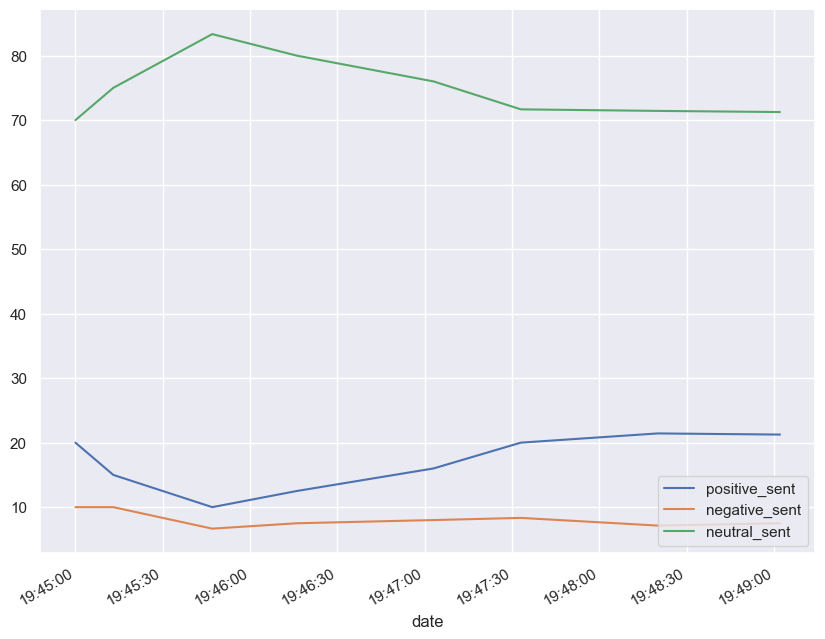

In [78]:
# Calcualte what percentage of sentiment is either positive negative or neutral
row_sum = tweet_df[['positive_sent', 'negative_sent', 'neutral_sent']].sum(axis=1)

tweet_df['positive_sent'] = tweet_df['positive_sent'] / row_sum * 100
tweet_df['negative_sent'] = tweet_df['negative_sent'] / row_sum * 100
tweet_df['neutral_sent'] = tweet_df['neutral_sent'] / row_sum * 100

window_size = 10

time_series_df = tweet_df.iloc[window_size-1::window_size]


sns.set_context("notebook")

# Plot the time series dataframe.
time_series_df.plot(y = ["positive_sent", "negative_sent", "neutral_sent"],
                    kind = "line",
                    figsize = (10, 8)).legend(loc='lower right')

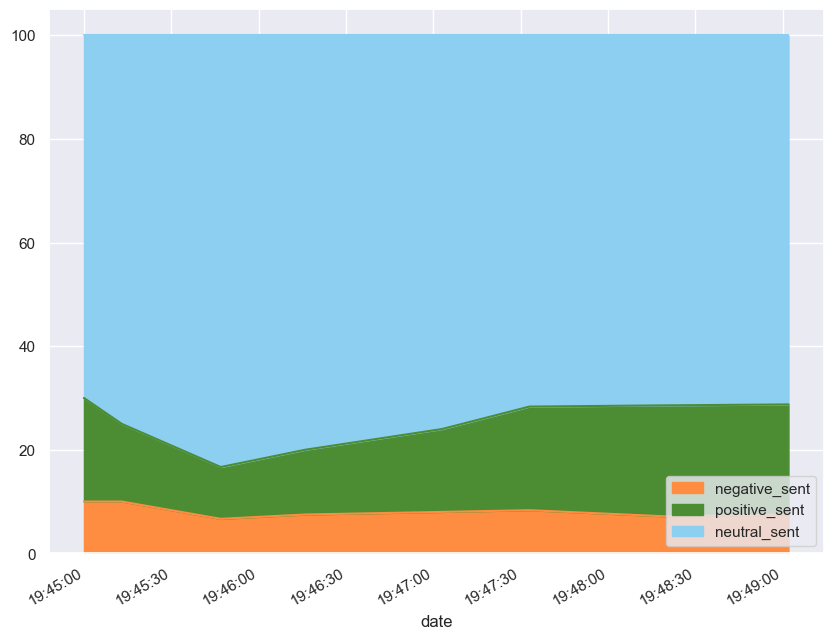

In [72]:
# Plot the time series data frame as an area graph
time_series_df.plot(y = ["negative_sent", "positive_sent",  "neutral_sent"],
                    kind = "area",
                    figsize = (10, 8),
                    color=( '#FF8D41', '#4C8D34', '#8CCFF0')).legend(loc='lower right')